Testing Flattened2Dpatches..
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 16, 192]) torch.Size([64])
Sample image size:  torch.Size([16, 3, 8, 8])


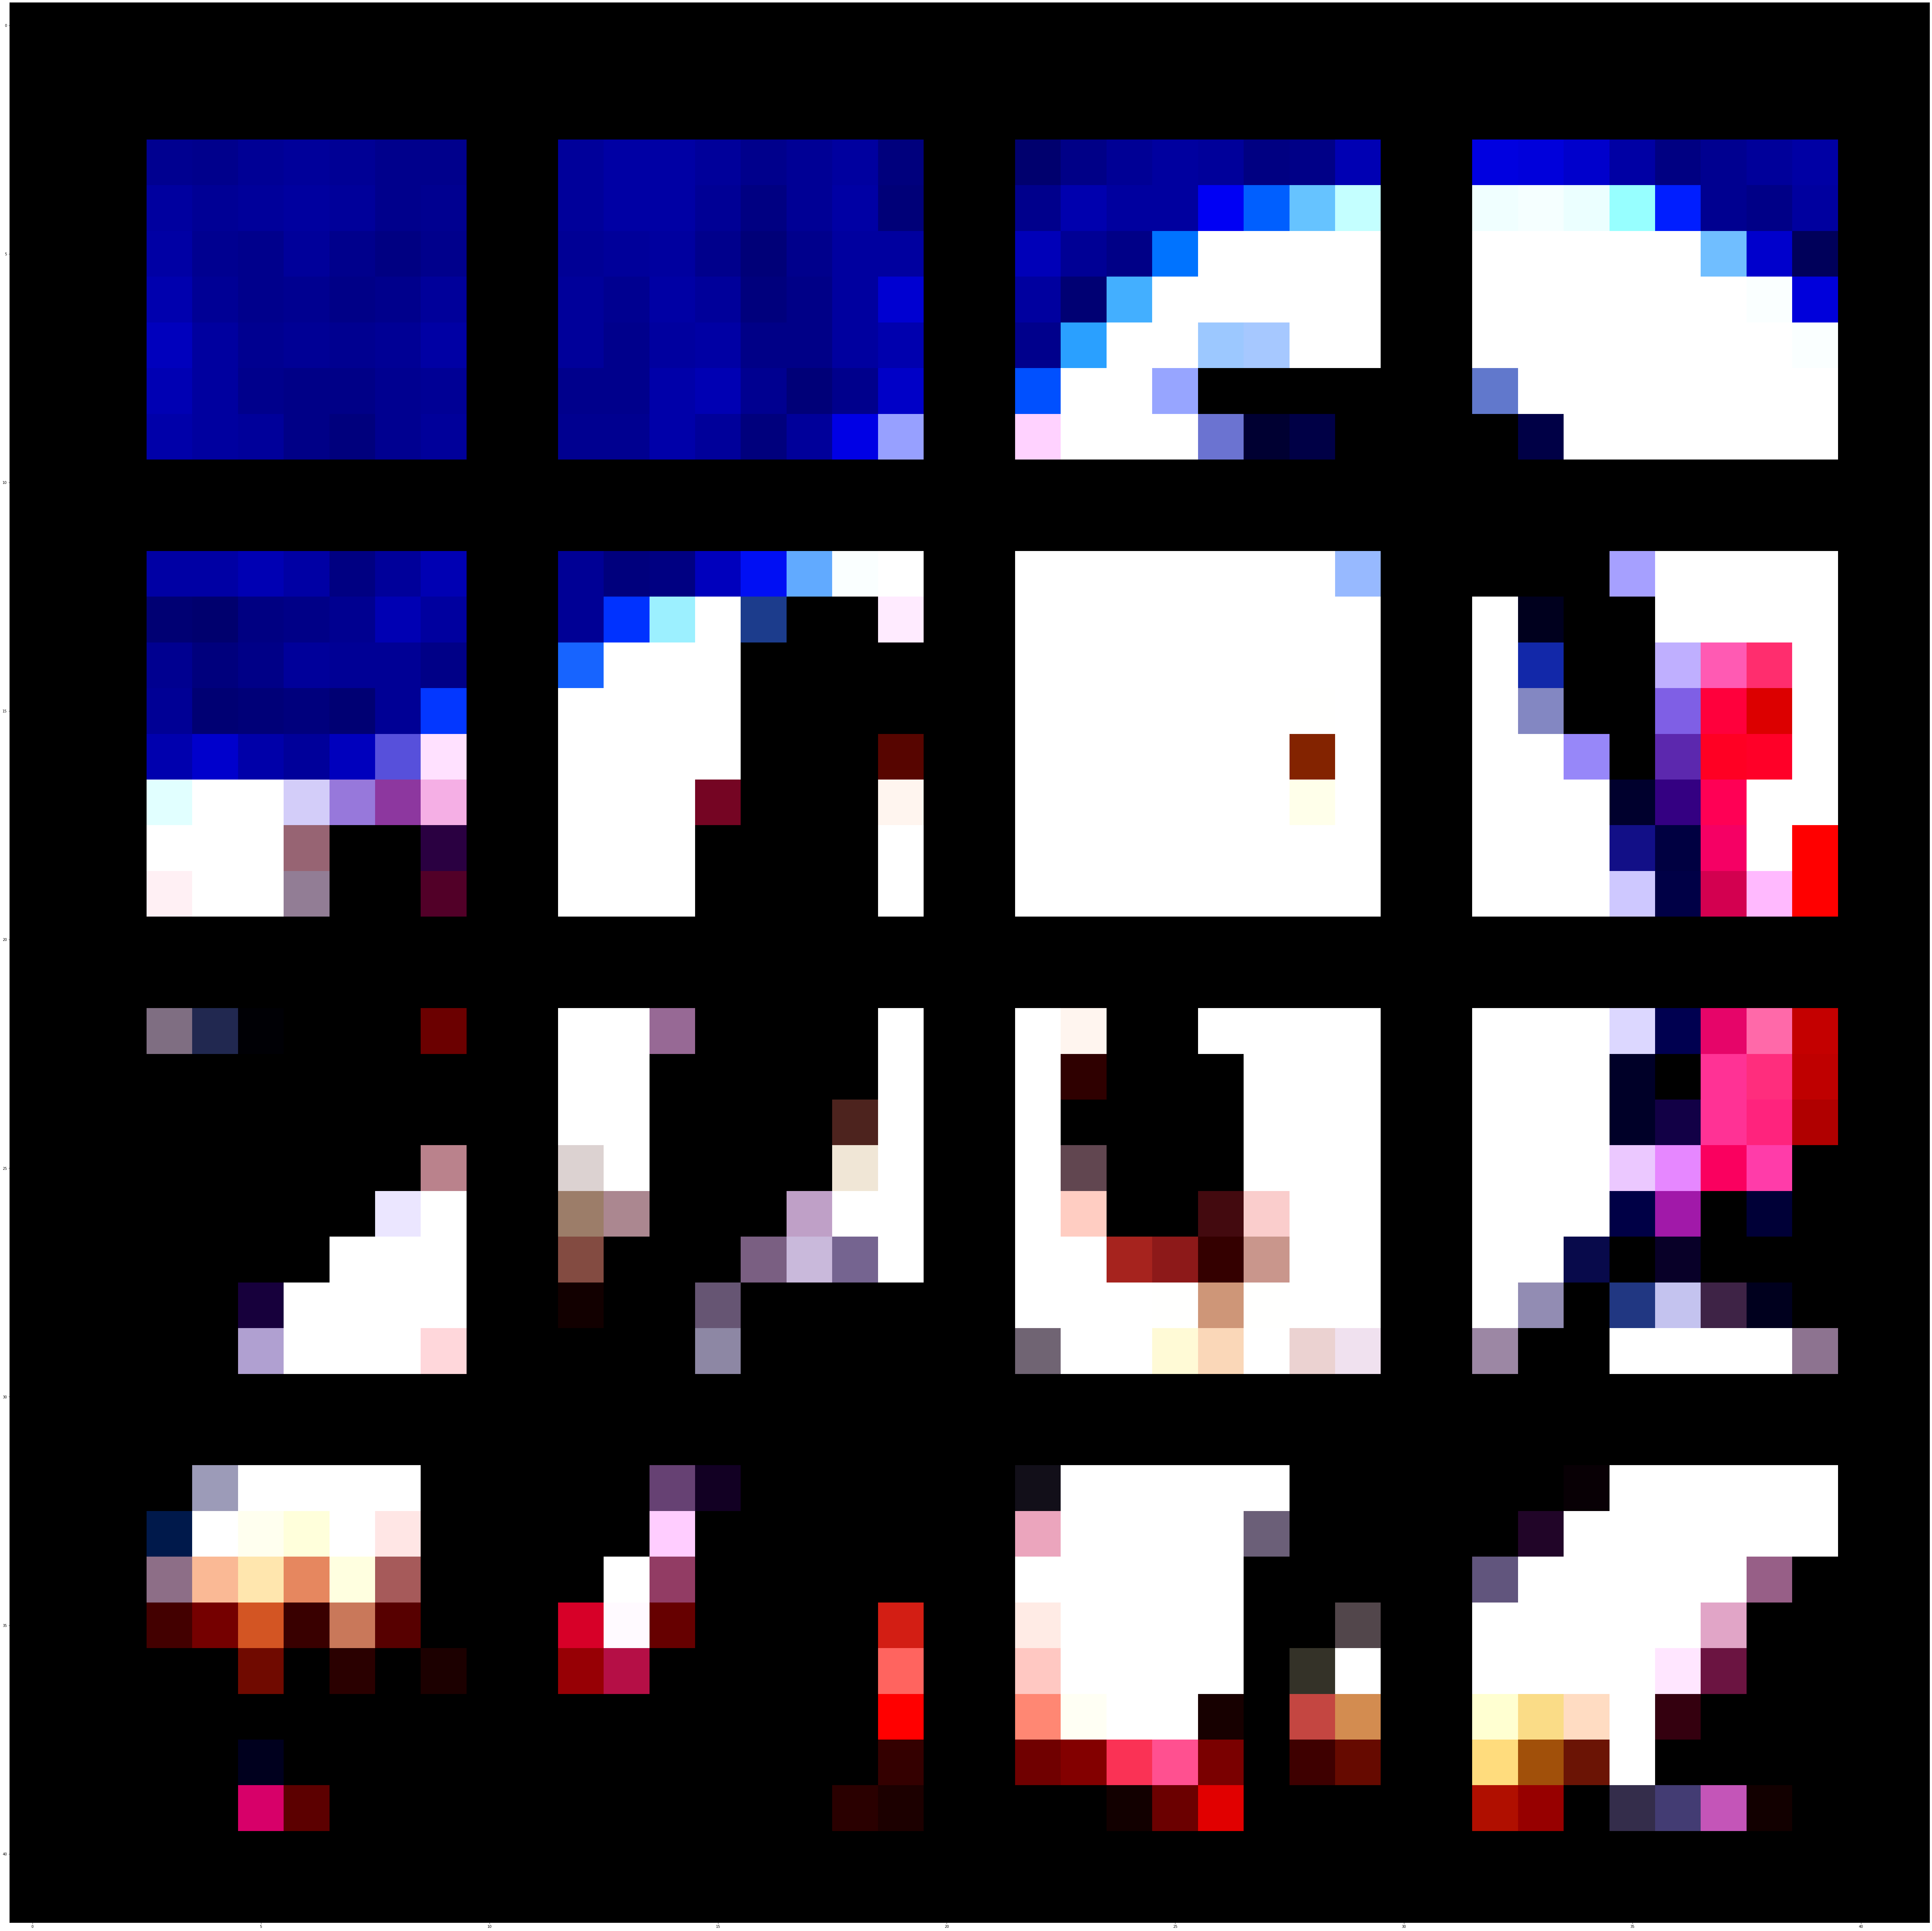

In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch

class PatchGenerator:

    def __init__(self, patch_size):
        self.patch_size = patch_size

    def __call__(self, img):
        num_channels = img.size(0)
        patches = img.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size).reshape(num_channels, -1, self.patch_size, self.patch_size)
        patches = patches.permute(1,0,2,3)
        num_patch = patches.size(0)

        return patches.reshape(num_patch,-1)

class Flattened2Dpatches:

    def __init__(self, patch_size=16, dataname='imagenet', img_size=256, batch_size=64):
        self.patch_size = patch_size
        self.dataname = dataname
        self.img_size = img_size
        self.batch_size = batch_size

    def make_weights(self, labels, nclasses):
        labels = np.array(labels)
        weight_arr = np.zeros_like(labels)
        _, counts = np.unique(labels, return_counts=True)
        for cls in range(nclasses):
            weight_arr = np.where(labels == cls, 1/counts[cls], weight_arr) 
    
        return weight_arr 

    def patchdata(self):
        mean = (0.4914, 0.4822, 0.4465)
        std = (0.2023, 0.1994, 0.2010)
        train_transform = transforms.Compose([transforms.Resize(self.img_size), transforms.RandomCrop(self.img_size, padding=2),
                                              transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean, std),
                                              PatchGenerator(self.patch_size)])
        test_transform = transforms.Compose([transforms.Resize(self.img_size), transforms.ToTensor(),
                                             transforms.Normalize(mean, std), PatchGenerator(self.patch_size)])

        if self.dataname == 'cifar10':
            trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
            testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
            evens = list(range(0, len(testset), 2))
            odds = list(range(1, len(testset), 2))
            valset = torch.utils.data.Subset(testset, evens)
            testset = torch.utils.data.Subset(testset, odds)
          
        elif self.dataname == 'imagenet':
            pass

        weights = self.make_weights(trainset.targets, len(trainset.classes))  # 가중치 계산
        weights = torch.DoubleTensor(weights)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))
        trainloader = DataLoader(trainset, batch_size=self.batch_size, sampler=sampler)
        valloader = DataLoader(valset, batch_size=self.batch_size, shuffle=False)
        testloader = DataLoader(testset, batch_size=self.batch_size, shuffle=False)

        return trainloader, valloader, testloader

def imshow(img):
    plt.figure(figsize=(100,100))
    plt.imshow(img.permute(1,2,0).numpy())
    plt.savefig('pacth_example.png')

if __name__ == "__main__":
    print("Testing Flattened2Dpatches..")
    batch_size = 64
    patch_size = 8
    img_size = 32
    num_patches = int((img_size*img_size)/(patch_size*patch_size))
    d = Flattened2Dpatches(dataname='cifar10', img_size=img_size, patch_size=patch_size, batch_size=batch_size)
    trainloader, _, _ = d.patchdata()
    images, labels = iter(trainloader).next()
    print(images.size(), labels.size())

    sample = images.reshape(batch_size, num_patches, -1, patch_size, patch_size)[0]
    print("Sample image size: ", sample.size())
    imshow(torchvision.utils.make_grid(sample, nrow=int(img_size/patch_size)))

In [4]:
images.shape

torch.Size([64, 16, 192])